# Closed-loop experimentation with active learning

#### METHOD
##### Active Exploration via Experiment Design in Markov Chains
The Experiment design is supposed to use a know markov chain to travel through all positions from the of the experiment design space.
And then choosing the best policies using reinforcement learning based on the policies selected in the previous step.
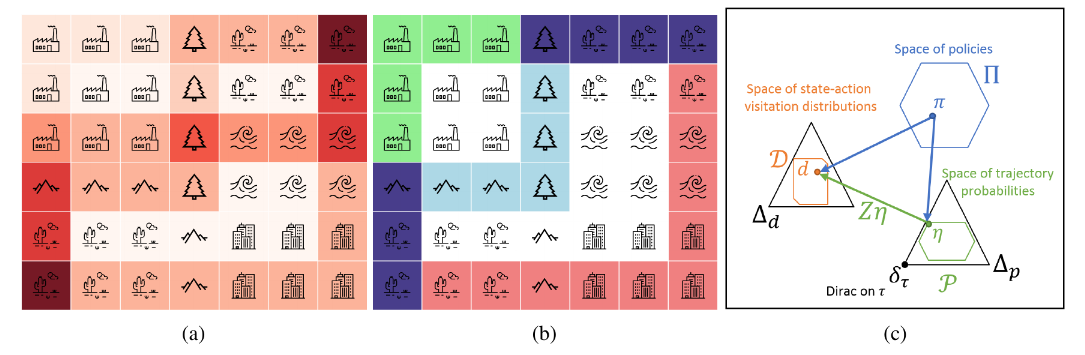
![image.png](attachment:image.png)

The approach is supposed to randomly choose between various Autora experimentalists
- random sampler
- Uncertainty
- Novelty
- Disagreement
- FFNRegressor

Since we have access to the ground truth we can use it to predict the outcomes from the next condition. Usind the ground truth to as a pseudo markov-chain.

Then keep count of the policies visited in each state. And then use that to choose the best policy to choose for each state.

In [ ]:
import sys, os

import numpy as np
import pandas as pd
from autora.experiment_runner.synthetic.utilities import describe

# Set the path to the project folder
target_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust path as needed
if target_folder not in sys.path:
    sys.path.append(target_folder)

from resources.synthetic import twoafc

from resources.regressors import FFN, FFNRegressor

In [ ]:
# basic experiment parameters

n_units = 100

noise_level = 0.0

parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 0, parameters)

In [ ]:
from resources.sampler import random_sampler
# from resources.regressors import FFNExperimenter

# define experiment
experiment = twoafc(parameters)

# define theorist
theorist = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)

In [ ]:
from autora.experimentalist.novelty import novelty_sample, novelty_score_sample
from autora.experimentalist.nearest_value import nearest_values_sample
from autora.experimentalist.model_disagreement import model_disagreement_sample
from autora.experimentalist.uncertainty import uncertainty_sample
from autora.theorist.bms import BMSRegressor
from autora.theorist.darts import DARTSRegressor
from sklearn.linear_model import LogisticRegression
from resources.regressors import FFNRegressor

import numpy as np

# Meta-Setup
# Meta-Setup
X = np.linspace(start=-3, stop=6, num=10).reshape(-1, 1)
y = (X**2).reshape(-1, 1)
n = 5
# Theorists
lr_theorist = LogisticRegression()
# lr_theorist.fit(X, y)
bms_theorist = BMSRegressor()
# bms_theorist.fit(X, y)
darts_theorist = DARTSRegressor()
# darts_theorist.fit(X, y)
# FFN_regrssor
ffn_regressor = FFNRegressor(FFN(n_units, 2), max_epochs=10, lr=0.1)

In [ ]:
from autora.state import StandardState, on_state, estimator_on_state

# define variable names
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]

# define seed condition data
conditions = random_sampler(experiment.variables, sample_all=["participant_id"])

# initialize state
s = StandardState(
    variables=experiment.variables,
    conditions=conditions,
    experiment_data=pd.DataFrame(columns=iv_names + dv_names),
    models=[theorist, lr_theorist, bms_theorist, darts_theorist, ffn_regressor],
)

##### Custom_sample_on_state
randomly chosses the experimentalist on the given state and chooses the next state.

<font color='red' size = 14> incomplete </font>

In [ ]:
from os import replace
import random
from autora.variable import ValueType
import itertools


### NOT USED - USED MIXTURE SAMPLER INSTEAD
# @on_state()
def custom_sample_on_state(s, sample_all, policies_known=False, num_samples=1):
    variables = s.variables
    replace = True
    iv = variables.independent_variables
    dv = variables.dependent_variables
    # X = s.experiment_data[iv_names].to_numpy()
    # y = s.experiment_data[dv_names].to_numpy()
    X = s.experiment_data[iv_names].to_numpy().astype(np.float64)
    y = s.experiment_data[dv_names].to_numpy().astype(np.float64)
    rng = np.random.default_rng(None)

    raw_conditions = {}
    if policies_known:
        ### WRITE to select policy given from current state directly.
        pass
    else:
        ### WRITE script to count the number of times policy chosen when each state is visited
        pass
    choice = random.choice([0, 1, 2, 3])
    choice = 3
    sample_all_combinations = sample_all
    for iv in variables.independent_variables:
        if iv.allowed_values is not None:
            if iv.name in sample_all:
                raw_conditions[iv.name] = iv.allowed_values
            else:
                raw_conditions[iv.name] = rng.choice(
                    iv.allowed_values, size=num_samples, replace=replace
                )
        elif (iv.value_range is not None) and (iv.type == ValueType.REAL):
            # raw_conditions[iv.name] = rng.uniform(*iv.value_range, size=num_samples)

            raw_conditions[iv.name] = rng.uniform(*iv.value_range, size=num_samples)
            # raw_conditions[iv.name] = [0, 1]
        else:
            raise ValueError(
                "allowed_values or [value_range and type==REAL] needs to be set for %s" % (iv)
            )
    all_conditions = []
    for iv_name in sample_all:
        all_conditions.append(raw_conditions.pop(iv_name))

    # Create a Cartesian product of all `sample_all` variables
    sample_all_combinations = list(itertools.product(*all_conditions))
    # print("X", sample_all_combinations)

    # Combine with randomly sampled variables
    other_conditions = pd.DataFrame(raw_conditions)
    choice = 0

    if choice == 0 or X.shape[0] < 1:
        pass

    # Experimentalist Uncert
    elif choice == 1:
        print(X, y)
        lr_theorist.fit(X, y)
        raw_conditions = uncertainty_sample(
            measure="least_confident",
            model=lr_theorist,
            num_samples=n,
            conditions=iv_names,
        )
        print("hERER")

    # Experimentalist Novelty
    elif choice == 2:
        raw_conditions = novelty_sample(conditions=iv_names, reference_conditions=X, num_samples=n)

    # Experimentalist Model disagre
    elif choice == 3:
        darts_theorist.fit(X, y)
        bms_theorist.fit(X, y)

        raw_conditions = model_disagreement_sample(
            conditions=other_conditions, models=[bms_theorist, darts_theorist], num_samples=n
        )
    elif choice == 4:
        # darts_theorist.fit(X, y)
        # bms_theorist.fit(X, y)
        ffn_regressor.fit(X, y)
        raw_conditions = ffn_regressor.predict(X)
        # return raw_conditions[]

    # Create the final dataframe
    final_rows = []
    for sample in sample_all_combinations:
        for _, row in other_conditions.iterrows():
            final_rows.append((*sample, *row.values))

    # Construct the final dataframe
    final_columns = sample_all + list(raw_conditions.keys())
    final_df = pd.DataFrame(final_rows, columns=final_columns)
    # s.conditions = final_df

    return final_df


In [ ]:
# wrap the loop components to make them operate on the state
# define experimentalist
# experimentalist = custom_sample_on_state
experimentalist = random_sampler
# experimentalist = meta_sampler
experiment_s = on_state(experiment.run, output=["experiment_data"])
experimentalist_s = on_state(experimentalist, output=["conditions"])
theorist_s = estimator_on_state(theorist)

<class 'autora.state.StandardState'>
StandardState(variables=VariableCollection(independent_variables=[IV(name='participant_id', value_range=(0, 99), allowed_values=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), units='', type=<ValueType.REAL: 'real'>, variable_label='participant_id', rescale=1, is_covariate=False), IV(name='ratio', value_range=(0.0, 1.0), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='ratio', rescale=1, is_covariate=False), IV(name='scatteredness', value_range=(0.0, 1.0), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label=

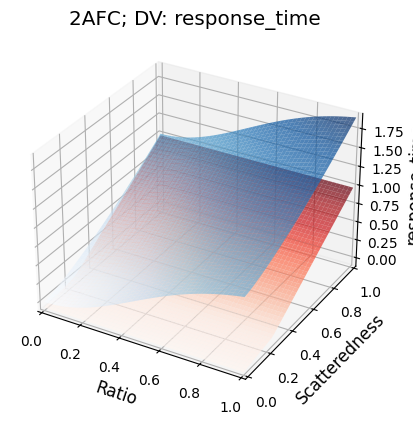

In [ ]:
# start the experimentation loop
# print(type(s))
for cycle in range(4):
    print(type(s))
    s = experimentalist_s(s, policies_known=False, sample_all=["participant_id"])
    print(s)
    # break
    s = experiment_s(s, added_noise=0.0, random_state=42 + cycle)
    s = theorist_s(s)

# plot the resulting model
experiment.plotter(s.models[0])

In [ ]:
print(type(s.conditions))

 <font color='red' size = 14>
The next step would be to count the times each policy is chosen at each state.

We were unable to get the experimentalists working with the on_state variables, hence unable to the next step.
</font>

We also attempted to use an mixture experimentalist. But it couldnt get it to run as well.

In [ ]:
# from autora.experimentalist.mixture import mixture_sample
# from autora.experimentalist.falsification import falsification_sample, falsification_score_sample
# from autora.experimentalist.novelty import novelty_sampler, novelty_score_sample
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.linear_model import LinearRegression

# lr_model = LinearRegression()
# lr_model.fit(X.to_numpy().reshape(-1, 1), y.to_numpy().reshape(-1))
# params = {
#     "novelty": {"reference_conditions": X},
#     "falsification": {"reference_conditions": X, "reference_observations": y, "model": lr_model},
# }
# experimentalist = mixture_sample(
#     conditions=new_X,
#     temperature=0.01,
#     samplers=[
#         [novelty_score_sample, "novelty", [0.7, 0.1]],
#         [falsification_score_sample, "falsification", [0.5, 0]],
#     ],
#     params=params,
#     num_samples=10,
# )